# This notebook contains code to produce 2D correlation plots 
## Will also show how to add wind regression coefficents as a quiver plot 


* Correlations are pearson correlations performed using scipy stats module 
* Regression is linear and performed using sklearn linear_model module 
* detrending is also linear and performed using scipy signal package 

In [1]:
import iris 
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import matplotlib.cm as cm

from scipy import signal
import scipy.stats as sp
from sklearn.linear_model import LinearRegression

import cartopy
import geopandas as gpd

* First lets load in our gridded data that we want to correlate our climate index with

In [2]:
directory = '/data/users/ncreaser/CSSP_china/data/variables/'
gridded_variable = '500hPa_geopot'
cube = iris.load_cube(f'{directory}ERA5_{gridded_variable}_monthly_1979_2019.nc')

* Instead of defining functions all at once, I'll define them as we go and explain what they do
* The function add coords, adds a month, year and season to the time coordinates

In [3]:
def add_coords(cube, seasons = ('djf','mam','jja','son')):
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_season(cube, 'time', name='season', seasons=seasons)

In [4]:
add_coords(cube)

In [5]:
cube.aux_coords

(<AuxCoord: month / (no_unit)  [Jan, Feb, ..., Nov, Dec]  shape(492,)>,
 <AuxCoord: season / (no_unit)  [djf, djf, ..., son, djf]  shape(492,)>,
 <AuxCoord: year / (1)  [1979, 1979, ..., 2019, 2019]  shape(492,)>)

* Can see our cooridnates have been added
* We can use these to make seasonal averages 
* Next we need to extract our relevent season, this is usually June, July, August (JJA) 

In [6]:
def extract_relevent_season(cube, season_name):
    constraint = iris.Constraint(season = season_name)
    return cube.extract(constraint)

In [7]:
season_cube = extract_relevent_season(cube, 'jja')

In [8]:
season_cube.aux_coords

(<AuxCoord: month / (no_unit)  [Jun, Jul, ..., Jul, Aug]  shape(123,)>,
 <AuxCoord: season / (no_unit)  [jja, jja, ..., jja, jja]  shape(123,)>,
 <AuxCoord: year / (1)  [1979, 1979, ..., 2019, 2019]  shape(123,)>)

* Now all of our seasons are jja
* Next we need to aggregate by year, so we average the Jun, Jul, Aug into jja 

In [9]:
season_cube = season_cube.aggregated_by(['year'], iris.analysis.MEAN)

In [10]:
season_cube.aux_coords

(<AuxCoord: month / (no_unit)  [Jun|Jul|Aug, ...]  shape(41,)>,
 <AuxCoord: season / (no_unit)  [jja|jja|jja, ...]  shape(41,)>,
 <AuxCoord: year / (1)  [1979, 1980, ..., 2018, 2019]  shape(41,)>)

* Now we have 41 years of jja, exactly what we need
* Now we need to detrend and normalise our gridded data at each gridpoint along the 41 year time series 

In [11]:
def detrend_normalise_cube(cube):
    detrend_data = signal.detrend(cube.data.reshape(cube.shape[0], -1), axis=0,overwrite_data=True) # detrend the data
    normalised = (detrend_data - np.mean(detrend_data, axis=0))/(np.std(detrend_data, axis=0))
    normalised = np.reshape(normalised,cube.shape)
    cube.data = normalised
    return cube

In [12]:
season_cube = detrend_normalise_cube(season_cube)

* Now we have our gridded data prepped, let's focus on our climate index

In [13]:
cli_index = 'iod'
cli_index_df = pd.read_csv(f'/data/users/ncreaser/CSSP_china/data/Indices/{cli_index}_monthly_longer.csv',  index_col='Year').loc[1979:2019]
cli_index_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1979,0.382,-0.078,0.066,-0.132,-0.364,0.222,-0.218,-0.114,-0.174,-0.154,-0.128,-0.032
1980,-0.093,-0.120,-0.317,-0.020,0.014,-0.268,-0.564,-0.710,-0.639,-0.498,-0.294,-0.413
1981,-0.136,0.056,0.127,0.168,0.062,-0.126,-0.463,-0.516,-0.651,-0.447,-0.204,0.050
1982,0.209,0.246,0.154,0.194,0.302,0.369,0.362,0.369,0.548,0.783,0.407,-0.093
1983,-0.416,-0.507,-0.652,-0.481,0.021,0.484,0.621,0.457,0.037,-0.128,-0.220,-0.031


* Use index_col command to specify the year
* Use .loc to ensure we have the correct time period 
* used .head() here to show the format this code expects the data to be in 

# CAUTION 
* We're going to be correlating the climate index month with the gridded variable avergaed in the summer 
* So if we want to use December climate index month, we need to change our time period for the climate index to be 1978:2018
* This is because if we keep it as is, Dec 1979 is after JJA 1979, so our correlation won't make sense as we're trying to look at how Decemeber climate index influences the summer, not the other way around. 
* If putting this code into a script, we can add some logic to do this for us
* For the purpose of this notebook, we will keep this interactive


* The next thing we need to do is select the month we are interested in and  detrend our climate index using scipy 

In [14]:
cli_index_month = cli_index_df.loc[:,'Mar']
cli_index_month = signal.detrend(cli_index_month.to_numpy())

* We also need to normalise this data ( make the mean = 0 and std_dev = 1) 

In [15]:
cli_index_month = (cli_index_month - np.mean(cli_index_month)) / np.std(cli_index_month)

### Data prep done - Lets focus on some correlations

* First we need to return some dummy cubes to fill with correlation data 
* the function return_pearson_cubes, returns a cube for correlation values and p values

In [16]:
def return_pearson_cubes(cube):
    ''' Takes a cube with a weather variable and renames etc '''
    corr_cube = cube[0].copy()
    corr_cube.long_name = 'Pearson Correlation Coefficient'
    corr_cube.standard_name = None
    corr_cube.units = ''
    
    corr_pvals_cube = cube[0].copy()
    corr_pvals_cube.long_name = 'p-values'
    corr_pvals_cube.standard_name = None
    corr_pvals_cube.units = ''

    return corr_cube, corr_pvals_cube

In [17]:
corr_cube, corr_pvals_cube = return_pearson_cubes(season_cube)

* Now we define a function to run our corrleation 
* as inputs it will take our gridded data, climate index, corr_cube and corr_pvaks_cube to fill with the results
* it will also take arguments of x and y coord to loop over

In [18]:
def run_correlations(normalised_cube, climate_index, corr_cube, corr_pvals_cube, y_coord = 'latitude', x_coord = 'longitude'):
    corr_cube_copy = corr_cube.copy()
    corr_pvals_cube_copy = corr_pvals_cube.copy()
    
    # Run over latitude and longitude (or alternative coordinates), and populate the cubes with correlation and p-value
    for i in range(len(normalised_cube.coord(y_coord).points)):
        for j in range(len(normalised_cube.coord(x_coord).points)):
            cube_by_gridpoint = normalised_cube.data[:, i, j]
            corrcoefs, p_vals = sp.pearsonr(climate_index, cube_by_gridpoint)
            corr_cube_copy.data[i,j] = corrcoefs
            corr_pvals_cube_copy.data[i,j] = p_vals
            
    return corr_cube_copy, corr_pvals_cube_copy

In [19]:
corr_cube_filled, corr_pvals_filled = run_correlations(season_cube, cli_index_month, corr_cube, corr_pvals_cube)

* Cool so we have our data - now we need to visulaise 
* Some of these functions arent strictly nessacary but help us visualise our region 
* The first free functions let us add shape files to highlight the farming region
* Plot correlations is the main function to produce our plot

In [20]:
def add_geometry_outline(geometry, edgecolor, ax, crs=cartopy.crs.PlateCarree(), **kwargs):
    ax.add_geometries(geometry, crs=crs, facecolor='none', edgecolor=edgecolor, **kwargs)


def add_geometry_fill(geometry, facecolor, ax, crs=cartopy.crs.PlateCarree(), **kwargs):
    ax.add_geometries(geometry, crs=crs, facecolor=facecolor, edgecolor='none', **kwargs)


def add_regions(ax, shapefile, region_colors, fill=False, **kwargs):
    if fill:
        for l, c in region_colors.items(): 
            add_geometry_fill(shapefile[shapefile.name==l].geometry, c, ax, **kwargs) 
    else:
        for l, c in region_colors.items(): 
            add_geometry_outline(shapefile[shapefile.name==l].geometry, c, ax, **kwargs) 
    ax.legend(handles=[mpatches.Patch(color=c, label=l, alpha = 0.6) for l, c in region_colors.items()], fontsize = 10)


def plot_correlations(corr_cube, corr_pvals_cube, projection, title = None, cmap = 'brewer_RdBu_11', subplot_num = None, shapefile=None, region_colors=None):
    
    contour_levels = np.arange(-1, 1.1, 0.2)
    
#     ax1 = plt.axes(projection = cartopy.crs.PlateCarree(central_longitude = 180))
    ax = plt.axes(projection = projection)
    ax1 = iplt.contourf(corr_cube, levels = contour_levels , cmap=cmap, axes = ax)
    #cax = plt.axes([0.15, 0.15, 0.7, 0.03])
    plt.gca().coastlines('50m', color = 'black')
    add_regions(ax, shapefile, region_colors, linewidth = 2, alpha = 0.6, fill= True)
    #plt.legend()
    cbar = plt.colorbar(ax1, orientation='horizontal', extend='both',
               label='', ticks=contour_levels, shrink = 0.5, anchor = (0.5,1.8))
    cbar.set_label('Correlation Values', fontsize = 16)
    cbar.ax.tick_params(labelsize = 14)
    try:
        iplt.contourf(corr_pvals_cube, colors='none', levels=[0.0, 0.05], hatches=['xxx'])
    except:
        print('no significant values')
    plt.title(title, fontsize = 16)

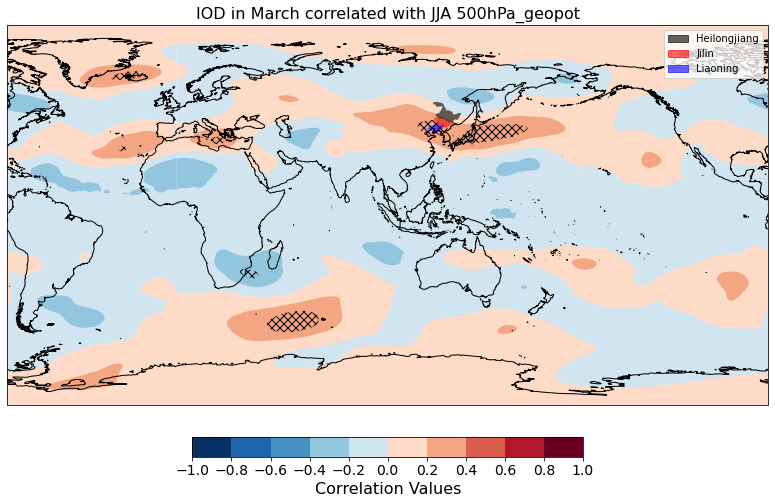

In [21]:
#loading in our shape files 
shapefile_path = "/project/cst/Projects/CSSP/CSSP_China/data/shapefiles/ne_10m_admin_1_states_provinces_shp_China.shp"
shapefile = gpd.read_file(shapefile_path)
region_colors = {"Heilongjiang": "k", "Jilin": "r", "Liaoning": "b"}

plt.figure(figsize = (14,10))
projection = cartopy.crs.PlateCarree(central_longitude=100)
title = f'{cli_index.upper()} in March correlated with JJA {gridded_variable}' 
plot_correlations(corr_cube_filled, corr_pvals_filled, projection, title = title, shapefile=shapefile,region_colors=region_colors)

# Now lets add some winds to this plot 
* We will perform a linear regression of u and v wind with the climate index
* these regression coefficients will then be plotting using a quiver plot
* this will go on top of our scaling 
* This processes is very similar to the one defined above, but instead of performing a correlation we do a regression

### First lets do the data processing 

In [22]:
u_cube = iris.load_cube(f'{directory}ERA5_200hPa_uwind_monthly_1979_2019.nc')
v_cube = iris.load_cube(f'{directory}ERA5_200hPa_vwind_monthly_1979_2019.nc')

In [23]:
add_coords(u_cube)
add_coords(v_cube)

In [24]:
u_cube_season = extract_relevent_season(u_cube, 'jja')
v_cube_season = extract_relevent_season(v_cube, 'jja')

In [25]:
u_cube_season = u_cube_season.aggregated_by(['year'], iris.analysis.MEAN)
v_cube_season = v_cube_season.aggregated_by(['year'], iris.analysis.MEAN)

In [26]:
u_cube_season = detrend_normalise_cube(u_cube_season)
v_cube_season = detrend_normalise_cube(v_cube_season)

* Now we've done out data prep we need to create a dummy cube again to write data to 

In [27]:
def return_regression_cube(cube, type_of_cube):
    reg_cube = cube[0].copy()
    reg_cube.long_name = type_of_cube
    reg_cube.standard_name = None
    reg_cube.units = ''
    return reg_cube

* now we can create a function to run our regression for us 
* Let's update our run correlations function to be able to handle this regression, keeping everything in the same place 

In [28]:
def run_correlations(normalised_cube, climate_index,corr_cube, corr_pvals_cube, u_cube = None, 
                     v_cube = None, y_coord = 'latitude', x_coord = 'longitude'):
    corr_cube_copy = corr_cube.copy()
    corr_pvals_cube_copy = corr_pvals_cube.copy()
    u_reg_cube = return_regression_cube(u_cube, 'Regression u cube')
    v_reg_cube = return_regression_cube(v_cube, 'Regression v cube')
    
    # Run over latitude and longitude (or alternative coordinates), and populate the cubes with correlation and p-value
    for i in range(len(normalised_cube.coord(y_coord).points)):
        for j in range(len(normalised_cube.coord(x_coord).points)):
            cube_by_gridpoint = normalised_cube.data[:, i, j]
            corrcoefs, p_vals = sp.pearsonr(climate_index, cube_by_gridpoint)
            corr_cube_copy.data[i,j] = corrcoefs
            corr_pvals_cube_copy.data[i,j] = p_vals
            
            # do regression 
            if u_cube is not None and v_cube is not None:
                u_cube_by_gridpoint = u_cube.data[:,i,j]
                v_cube_by_gridpoint = v_cube.data[:,i,j]

                u_reg = LinearRegression().fit(climate_index.reshape(-1,1), u_cube_by_gridpoint.reshape(-1,1))
                u_reg_cube.data[i,j] = u_reg.coef_[0][0]
                
                v_reg = LinearRegression().fit(climate_index.reshape(-1,1), v_cube_by_gridpoint.reshape(-1,1))
                v_reg_cube.data[i,j] = v_reg.coef_[0][0]
            
    return corr_cube_copy, corr_pvals_cube_copy, u_reg_cube, v_reg_cube

In [29]:
corr_cube_filled, corr_pvals_filled, u_reg_cube, v_reg_cube = run_correlations(season_cube, cli_index_month, corr_cube, corr_pvals_cube, u_cube_season, v_cube_season)

* Now that we've done our regression, we can use the same plotting routine as before but now adding a quiver plot 
* This is just one line of code usuing iris plot

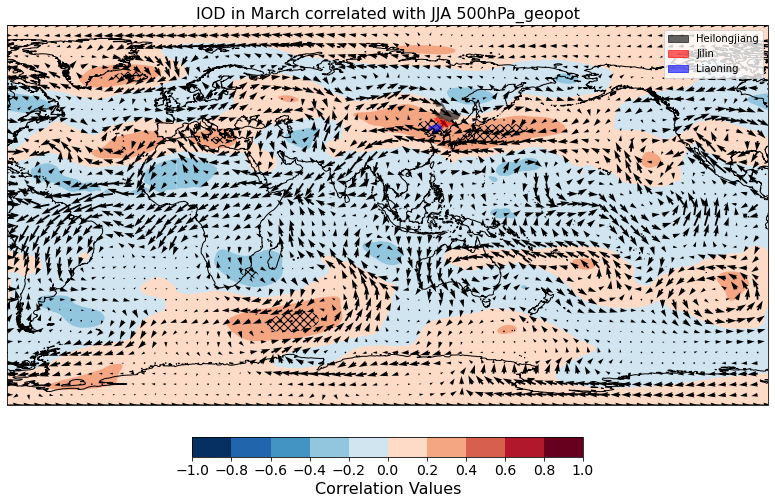

In [30]:
#loading in our shape files 
shapefile_path = "/project/cst/Projects/CSSP/CSSP_China/data/shapefiles/ne_10m_admin_1_states_provinces_shp_China.shp"
shapefile = gpd.read_file(shapefile_path)
region_colors = {"Heilongjiang": "k", "Jilin": "r", "Liaoning": "b"}

plt.figure(figsize = (14,10))
projection = cartopy.crs.PlateCarree(central_longitude=100)
title = f'{cli_index.upper()} in March correlated with JJA {gridded_variable}' 
plot_correlations(corr_cube_filled, corr_pvals_filled, projection, title = title, shapefile=shapefile,region_colors=region_colors)

Q = iplt.quiver(u_reg_cube[::20, ::20], v_reg_cube[::20, ::20])